# Observations Vs. Model Difference Plots

In [1]:
import xarray as xr
import xoak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    #load the geog file produce for WRF-BCC
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    #coarsen the dataset to ~80-km
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    #assign lat/lon values of coarsen data and set index
    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#d1e5f0',
                  '#f7f7f7',
                  '#fddbc7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-22.5, 22.5, num=10)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

In [4]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc').sel(Time='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_coarse = Data_Conv(ds_copy)

### Load and Coarsen Data

In [5]:
#load wrf-bcc dataset
df_wrf = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UH_REFC_regrid_threshold_dataframe.csv')

#convert from raw count to convective days
#change so that 0z is 12z
df_wrf['Time'] = pd.to_datetime(df_wrf['Time'])
df_wrf['New_Time'] = pd.to_datetime(df_wrf['Time']) + pd.DateOffset(hours=12)

#seperate timing values into their own column
df_wrf['Year'] = pd.to_datetime(df_wrf['New_Time']).dt.year
df_wrf['Month'] = pd.to_datetime(df_wrf['New_Time']).dt.month
df_wrf['Day'] = pd.to_datetime(df_wrf['New_Time']).dt.day

#subset the data by the best Z and UH threshold
df_wrf = df_wrf[((df_wrf['DBZ'] >= 40.0) & (df_wrf['UH'] >= 65.0))]

#drop duplicate days
df_wrf = df_wrf.drop_duplicates(subset=['coarse_lat','coarse_lon','Year', 'Month','Day'])
df_wrf

,Unnamed: 0.1,Unnamed: 0,x,y,Time,UH,DBZ,UVV,coarse_lat,coarse_lon,New_Time,Year,Month,Day
84,207,207,815,310,1990-11-13 22:00:00,65.640820,43.941685,12.644648,33.718674,-92.81139,1990-11-14 10:00:00,1990,11,14
189,702,702,730,213,1990-11-16 11:00:00,66.957886,45.891376,12.088850,30.556082,-96.29785,1990-11-16 23:00:00,1990,11,16
190,703,703,731,213,1990-11-16 11:00:00,65.548130,54.683743,11.790516,30.556082,-96.25520,1990-11-16 23:00:00,1990,11,16
274,842,842,744,212,1990-11-16 12:00:00,65.504800,40.982204,16.095740,30.519302,-95.69520,1990-11-17 00:00:00,1990,11,17
425,1312,1312,696,86,1990-11-20 12:00:00,68.051220,45.232010,19.190866,26.347475,-97.83956,1990-11-21 00:00:00,1990,11,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052779,3052166,222339,1175,446,2005-09-18 02:00:00,75.819580,46.267258,14.909941,36.640910,-77.34906,2005-09-18 14:00:00,2005,9,18
1052780,3052167,222340,1176,446,2005-09-18 02:00:00,77.304924,50.917170,14.515182,36.640910,-77.28058,2005-09-18 14:00:00,2005,9,18
1052781,3052168,222341,1177,446,2005-09-18 02:00:00,71.834600,52.575623,14.257374,36.606743,-77.25557,2005-09-18 14:00:00,2005,9,18
1052782,3052175,222348,1175,447,2005-09-18 02:00:00,75.259514,43.665665,13.869192,36.664608,-77.34906,2005-09-18 14:00:00,2005,9,18


In [6]:
#create an array of zeros
zeros = np.zeros(ds_copy.UP_HELI_MAX.values.shape)

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_wrf.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
#nan all the zero values    
zeros[zeros == 0.0] = np.nan

#assign the array to the netcdf file
ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

#coarsen the file 
ds_cor = Data_Conv(ds)    

In [7]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_hail = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_hail_fix.csv')
df_tor = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_tor_fix.csv')
df_wind = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_wind_fix.csv')

#concat the dataframes into one
df_obs = pd.concat([df_hail, df_tor, df_wind])
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,sn,sg,f1,f2,f3,f4,geometry,Nearest,fc,mt
0,0,47291,3560,1990,10,16,1990-10-16,17:45:00,3,TX,...,0,0,371,0,0,0,POINT (-102.68 31.23),"(787 30.997099\nName: lat, dtype: float32, ...",NaN,NaN
1,1,47292,3561,1990,10,17,1990-10-17,07:24:00,3,WI,...,0,0,47,0,0,0,POINT (-88.93 43.88),"(2114 43.597301\nName: lat, dtype: float32,...",NaN,NaN
2,2,47293,3562,1990,10,17,1990-10-17,08:35:00,3,MN,...,0,0,17,0,0,0,POINT (-92.45 46.72),"(2386 46.476452\nName: lat, dtype: float32,...",NaN,NaN
3,3,47294,3563,1990,10,17,1990-10-17,12:50:00,3,IA,...,0,0,123,0,0,0,POINT (-92.67 41.47),"(1903 41.786617\nName: lat, dtype: float32,...",NaN,NaN
4,4,47295,3564,1990,10,17,1990-10-17,13:10:00,3,IA,...,0,0,157,0,0,0,POINT (-92.42 41.58),"(1903 41.786617\nName: lat, dtype: float32,...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149333,149333,227489,10508,2005,9,9,2005-09-09,13:15:00,3,MN,...,0,0,119,0,0,0,NaN,"(2520 47.90831\nName: lat, dtype: float32, ...",NaN,NaN
149334,149334,227490,10509,2005,9,9,2005-09-09,14:52:00,3,UT,...,0,0,37,0,0,0,NaN,"(1469 37.189175\nName: lat, dtype: float32,...",NaN,NaN
149335,149335,227491,10510,2005,9,9,2005-09-09,17:10:00,3,AZ,...,0,0,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",NaN,NaN
149336,149336,227492,10511,2005,9,9,2005-09-09,18:20:00,3,AZ,...,0,0,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",NaN,NaN


In [8]:
#add the lat and lon columns based on values in the nearest column
lat = []
lon = []

#iterate through each row to find the lat/lon
for rid, row in df_obs.iterrows():
    lat.append(row.Nearest.split()[1])
    lon.append(row.Nearest.split()[7])

#append the values to the dataframe
df_obs['Lat'] = lat
df_obs['Lon'] = lon

#combine date and time to a datetime object
df_obs['datetime'] = pd.to_datetime(df_obs['date'] + ' ' + df_obs['time']) + pd.DateOffset(hours=6)
df_obs['con_date'] = (df_obs['datetime'] + pd.DateOffset(hours=12)).dt.date

#drop duplicates to convert to convective days
df_obs = df_obs.drop_duplicates(subset=['Lat','Lon','con_date'])
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,f3,f4,geometry,Nearest,fc,mt,Lat,Lon,datetime,con_date
0,0,47291,3560,1990,10,16,1990-10-16,17:45:00,3,TX,...,0,0,POINT (-102.68 31.23),"(787 30.997099\nName: lat, dtype: float32, ...",NaN,NaN,30.997099,-102.556038,1990-10-16 23:45:00,1990-10-17
1,1,47292,3561,1990,10,17,1990-10-17,07:24:00,3,WI,...,0,0,POINT (-88.93 43.88),"(2114 43.597301\nName: lat, dtype: float32,...",NaN,NaN,43.597301,-88.64975,1990-10-17 13:24:00,1990-10-18
2,2,47293,3562,1990,10,17,1990-10-17,08:35:00,3,MN,...,0,0,POINT (-92.45 46.72),"(2386 46.476452\nName: lat, dtype: float32,...",NaN,NaN,46.476452,-92.139168,1990-10-17 14:35:00,1990-10-18
3,3,47294,3563,1990,10,17,1990-10-17,12:50:00,3,IA,...,0,0,POINT (-92.67 41.47),"(1903 41.786617\nName: lat, dtype: float32,...",NaN,NaN,41.786617,-92.507233,1990-10-17 18:50:00,1990-10-18
5,5,47296,3565,1990,10,17,1990-10-17,15:50:00,3,TX,...,0,0,POINT (-97.35 32.93),"(1001 33.126812\nName: lat, dtype: float32,...",NaN,NaN,33.126812,-97.078918,1990-10-17 21:50:00,1990-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149331,149331,227487,10506,2005,9,9,2005-09-09,12:50:00,3,MN,...,0,0,NaN,"(2521 47.893795\nName: lat, dtype: float32,...",NaN,NaN,47.893795,-94.99498,2005-09-09 18:50:00,2005-09-10
149332,149332,227488,10507,2005,9,9,2005-09-09,13:00:00,3,MN,...,0,0,NaN,"(2452 47.228268\nName: lat, dtype: float32,...",NaN,NaN,47.228268,-95.021698,2005-09-09 19:00:00,2005-09-10
149333,149333,227489,10508,2005,9,9,2005-09-09,13:15:00,3,MN,...,0,0,NaN,"(2520 47.90831\nName: lat, dtype: float32, ...",NaN,NaN,47.90831,-95.986839,2005-09-09 19:15:00,2005-09-10
149334,149334,227490,10509,2005,9,9,2005-09-09,14:52:00,3,UT,...,0,0,NaN,"(1469 37.189175\nName: lat, dtype: float32,...",NaN,NaN,37.189175,-109.790741,2005-09-09 20:52:00,2005-09-10


In [9]:
#create an array of zeros
zeros = np.zeros((ds_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_cor.lat.values == float(row.Lat))
    y2, x2 = np.where(ds_cor.lon.values == float(row.Lon))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

In [16]:
deltas = ds_cor.UP_HELI_MAX.values - ds_obs.UP_HELI_MAX.values

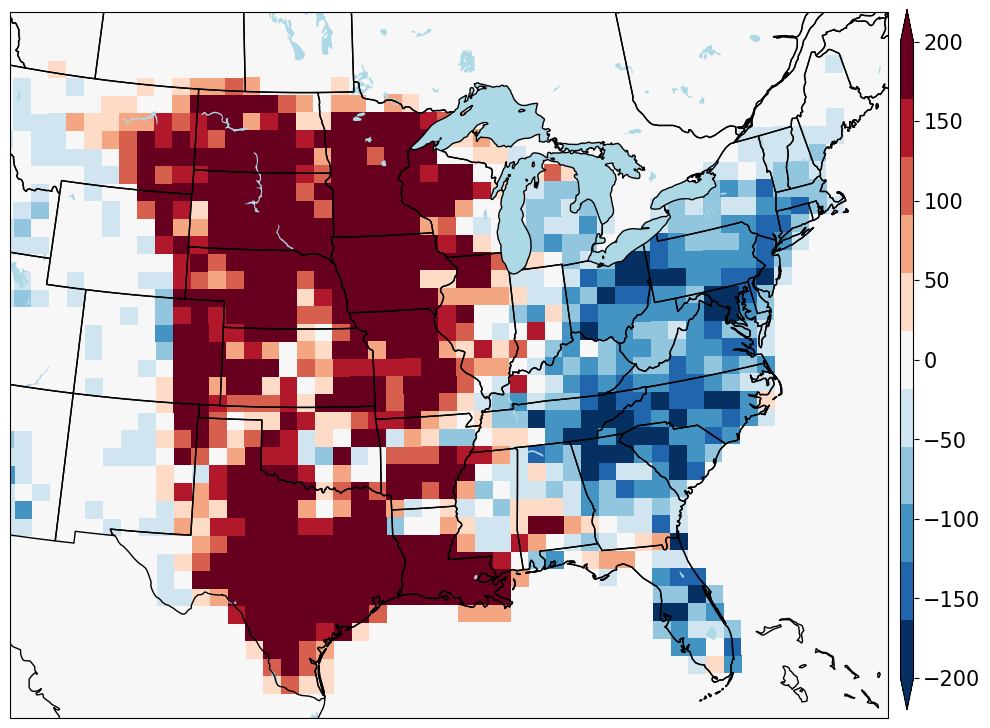

In [17]:
from matplotlib import colors

#Plot the data
fig = plt.figure()
plt.rcParams['figure.figsize'] = 13,10
divnorm=colors.TwoSlopeNorm(vmin=-200., vcenter=0., vmax=200)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

#iterate through the modes and seasons
plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)

ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, deltas,
                  transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax.set_extent([-110, -74, 24.5, 50])

#ax.annotate(f'{letter[i-1]})', (0.05,0.05),fontsize=16, xycoords='axes fraction')

cbar = plt.colorbar(c, ticks=list(range(-200, 201, 50)), pad=0.01, extend='both', ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)

#cbar.set_label(label='$\Delta$Days', size=10)
plt.show()